[View in Colaboratory](https://colab.research.google.com/github/arpitsharma9/01_machine_learning/blob/master/02_cnn/cifar10_cnn.ipynb)

# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

---

In this notebook, we train a CNN to classify images from the CIFAR-10 database.

### 1. Load CIFAR-10 Database

In [1]:
## reference 

#https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

from __future__ import print_function

import tensorflow as tf

from keras.datasets import cifar10
## TPU performance is bit slow... let's optimize TPU later.. let's execute over model om GPU
'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint 
'''
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,LeakyReLU
from keras.callbacks import ModelCheckpoint 
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
 
import os

# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
## define some variables
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
#data_augmentation = False
num_predictions = 20
#save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'keras_cifar10_trained_model.h5'

In [3]:
import os
import pprint

## not using TPU's
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  #tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  # This address identifies the TPU we'll use when configuring TensorFlow.
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']  
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)
  


ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!


### 2. Visualize the First 36 Training Images

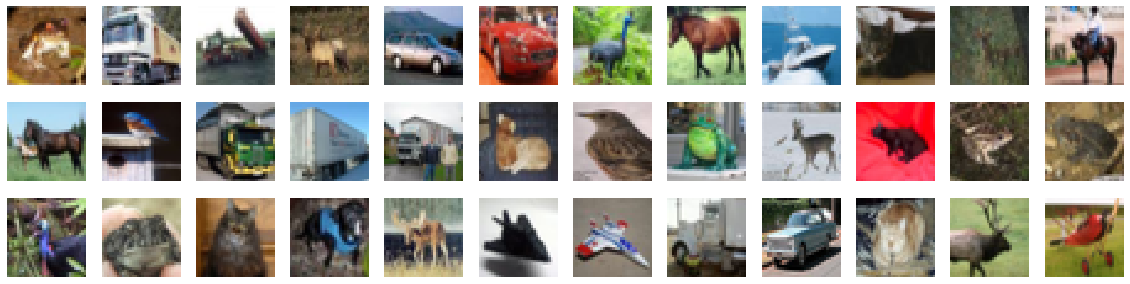

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

### 3. Rescale the Images by Dividing Every Pixel in Every Image by 255

In [0]:
# rescale [0,255] --> [0,1]
# If we do not convert this to float, then most of the values will be zero... 240/255=0, but 240.0/255=0.94
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

### 4.  Break Dataset into Training, Testing, and Validation Sets

In [6]:
# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# break training set into training and validation sets
#(x_train, x_valid) = x_train[5000:], x_train[:5000]
#(y_train, y_valid) = y_train[5000:], y_train[:5000]
x_train, x_valid,y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=42)


# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


### 5. Define the Model Architecture 

In [0]:
## define the model architecture

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### 6. Compile the Model 

In [0]:
# compile the model
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# use below optimizer if you are running on TPU
#opt=tf.train.RMSPropOptimizer(learning_rate=0.01,decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

### 6. Image augmentation to the data

In [9]:
if not data_augmentation:
    print('Not using data augmentation.')
    
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    
    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)


Using real-time data augmentation.


### 8. Train the Model 

In [0]:
## Let's invole TPU Model here.

'''
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
'''
# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
'''
hist = model.fit(x_train, y_train, batch_size=32, epochs=5,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)
'''
# Fit the model on the batches generated by datagen.flow().

if not data_augmentation:
  hist = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

else:
  hist = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_valid, y_valid),callbacks=[checkpointer], 
          verbose=2, workers=4)
  


Epoch 1/100
 - 42s - loss: 1.8736 - acc: 0.3098 - val_loss: 1.6120 - val_acc: 0.4156

Epoch 00001: val_loss improved from inf to 1.61199, saving model to model.weights.best.hdf5
Epoch 2/100
 - 40s - loss: 1.6026 - acc: 0.4116 - val_loss: 1.4527 - val_acc: 0.4686

Epoch 00002: val_loss improved from 1.61199 to 1.45273, saving model to model.weights.best.hdf5
Epoch 3/100
 - 40s - loss: 1.4895 - acc: 0.4571 - val_loss: 1.3396 - val_acc: 0.5150

Epoch 00003: val_loss improved from 1.45273 to 1.33962, saving model to model.weights.best.hdf5
Epoch 4/100
 - 40s - loss: 1.3995 - acc: 0.4979 - val_loss: 1.2689 - val_acc: 0.5478

Epoch 00004: val_loss improved from 1.33962 to 1.26888, saving model to model.weights.best.hdf5
Epoch 5/100
 - 39s - loss: 1.3336 - acc: 0.5234 - val_loss: 1.2359 - val_acc: 0.5554

Epoch 00005: val_loss improved from 1.26888 to 1.23594, saving model to model.weights.best.hdf5
Epoch 6/100
 - 40s - loss: 1.2790 - acc: 0.5461 - val_loss: 1.1574 - val_acc: 0.5866

Epoch 00

### 9. Load the Model with the Best Validation Accuracy

In [0]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

### 10. Calculate Classification Accuracy on Test Set

In [82]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.5484


### 11. Visualize Some Predictions

This may give you some insight into why the network is misclassifying certain objects.

In [83]:
# get predictions on the test set
y_hat = model.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#y_hat[0]*100 - max probabilty for cat.
#y_test[0] - cat
np.argmax(y_hat[0])

3

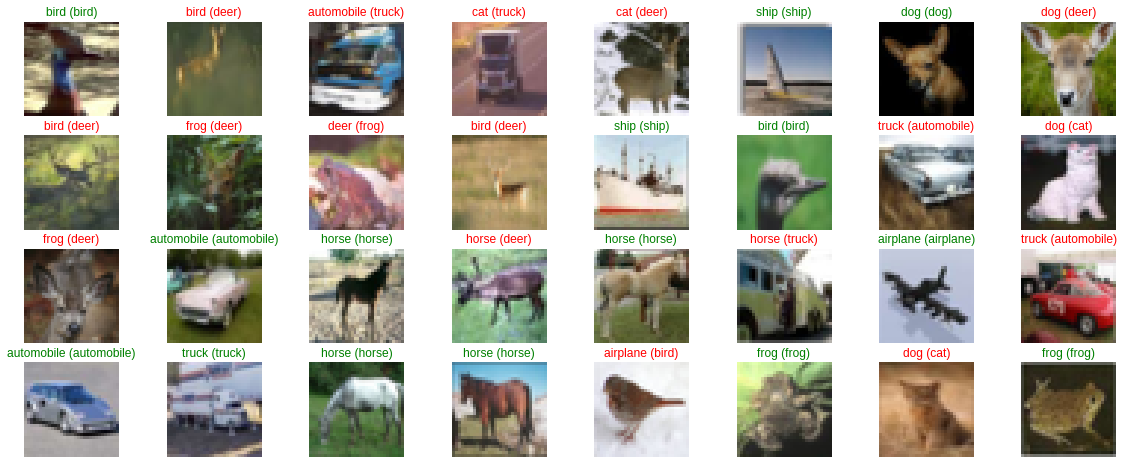

In [84]:
# plot a random sample of test images, their predicted labels, and ground truth
##x_test.shape[0] - basically i get the number of samples in testset.. i.e 10,000
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ## argmax will returns the indices of the maximum values along an axis.
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))